# BENO-Investigation

# Training

In [1]:
import os
os.getcwd()

'c:\\Users\\zzh\\Desktop\\Oxford\\GeometricDeepLearning\\beno'

In [2]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint as pp
from timeit import default_timer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import scatter  # Not included in the latest version
from torchvision.transforms import GaussianBlur
import sys, os
# from utilities import *
from utilities import MeshGenerator,GaussianNormalizer,LpLoss
from util import record_data, to_cpu, to_np_array, make_dir
from BE_MPNN import HeteroGNS
import random
from loguru import logger
import matplotlib.tri as tri
from torch_geometric.data import HeteroData
import warnings
warnings.filterwarnings('ignore')
import pdb
fix_seed = 2023
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
torch.cuda.manual_seed_all(fix_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


## 1. Set training arguments

In [3]:
class Args:
    epochs = 100
    lr = 0.00005
    inspect_interval = 100
    id = "0"
    init_boudary_loc = "regular"
    trans_layer = 3
    boundary_dim = 128
    batch_size = 1
    act = "silu"
    nmlp_layers = 3
    ns = 10

args = Args()


## 2. Load Data

We aim to solve a $d$-dimensional-differntiable function $u \in C^d(\mathbb R)$ of $N$ interior grid nodes over an open domain $\Omega$. This paper primarily works with Poisson equation with Dirichlet boundar conditions. E.g. for $d = 2$ the data is 
$$ \nabla^2 u ([x_1, x_2, \dots, x_d)]) = f([x_1, x_2, \dots, x_d]), \quad \forall ([x_1, \dots, x_d]) \in \Omega$$
$$ u ([x_1, x_2, \dots, x_d)]) = g([x_1, x_2, \dots, x_d]), \quad \forall ([x_1, \dots, x_d]) \in \partial \Omega.$$

Here we load a sample of 10 4-corner dataset

In [4]:

DATA_PATH = f"C:/Users/zzh/Desktop/Oxford/GeometricDeepLearning/beno/data/"
f_all = np.load(DATA_PATH + "RHS_N32_10.npy") # the source function
sol_all = np.load(DATA_PATH + "SOL_N32_10.npy") # the solution
bc_all=np.load(DATA_PATH + "BC_N32_10.npy") # the boundary condition
ntrain = 7
ntest =3

In [5]:
print(f_all.shape)
print(sol_all.shape)
print(bc_all.shape)


(10, 1024, 4)
(10, 1024, 1)
(10, 128, 4)


In [6]:
gblur = GaussianBlur(kernel_size=5, sigma=5)


batch_size = args.batch_size
batch_size2 = args.batch_size
width = 64
ker_width = 256
depth = 4
edge_features = 7
node_features = 10
ns=args.ns
epochs = args.epochs
learning_rate = args.lr
inspect_interval = args.inspect_interval

runtime = np.zeros(2, )
t1 = default_timer()

resolution = 32
s = resolution
n=s**2


trans_layer = args.trans_layer

path = 'Resolution_' + str(s) + '_poisson' + \
    '_ntrain'+str(ntrain)+'_kerwidth'+str(ker_width) + '_Transformer_layer' + str(args.trans_layer) +\
    '_Rolling' + args.init_boudary_loc+'_ns'+str(args.ns)+\
    '_nheads2'+'_bddim'+str(args.boundary_dim)+"_act"+args.act+'lr'+str(args.lr)+'_nmlp_layers'+str(args.nmlp_layers)
path_model = 'C:/Users/zzh/Desktop/Oxford/GeometricDeepLearning/beno/results/' + path
make_dir(path_model)

logger.add(os.path.join('log', '{}.log'.format(
            path)), rotation="500 MB", level="INFO")
logger.info(path)
   

2025-03-31 00:13:23.241 | INFO     | __main__:<module>:35 - Resolution_32_poisson_ntrain7_kerwidth256_Transformer_layer3_Rollingregular_ns10_nheads2_bddim128_actsilulr5e-05_nmlp_layers3


Check the shape of the dataset. This is an example of 32 x 32 2D grid.

In [7]:
print(f_all.shape)
print(sol_all.shape)
print(bc_all.shape)


(10, 1024, 4)
(10, 1024, 1)
(10, 128, 4)


In [8]:
cells_state=f_all[:,:,3] # node type \in {0,1,2,3}
coord_all=f_all[:,:,0:2] # all node corrdinate

bc_euco=bc_all[:,:,0:2]  # boundary corrdinate
bc_value=bc_all[:,:,2].reshape(-1,128,1)   # boundary value
bc_value=torch.tensor(bc_value)  
bc_value_1=bc_value[0:900,:,:] 
bc_euco=torch.tensor(bc_euco)
bcv_normalizer = GaussianNormalizer(bc_value_1) 
bc_value = bcv_normalizer.encode(bc_value)
bc_euco= to_np_array(torch.cat([bc_euco,bc_value],dim=-1))

all_a = f_all[:,:,2] # actual source function values
all_a_smooth = to_np_array(gblur(torch.tensor(all_a.reshape(all_a.shape[0], resolution, resolution))).flatten(start_dim=1))   
all_a_reshape = all_a_smooth.reshape(-1, resolution, resolution)

# Calculate gradient using finite difference
all_a_gradx = np.concatenate([
    all_a_reshape[:,1:2] - all_a_reshape[:,0:1],
    (all_a_reshape[:,2:] - all_a_reshape[:,:-2]) / 2,
    all_a_reshape[:,-1:] - all_a_reshape[:,-2:-1],
], 1)
all_a_gradx = all_a_gradx.reshape(-1, n)
all_a_grady = np.concatenate([
    all_a_reshape[:,:,1:2] - all_a_reshape[:,:,0:1],
    (all_a_reshape[:,:,2:] - all_a_reshape[:,:,:-2]) / 2,
    all_a_reshape[:,:,-1:] - all_a_reshape[:,:,-2:-1],
], 2)
all_a_grady = all_a_grady.reshape(-1, n)
all_u = sol_all[:,:,0]

# Setting up train and test dataset
train_a = torch.FloatTensor(all_a[:ntrain])  # [num_train, 4096]
train_a_smooth = torch.FloatTensor(all_a_smooth[:ntrain]) # [num_train, 4096]
train_a_gradx = torch.FloatTensor(all_a_gradx[:ntrain])   # [num_train, 4096]
train_a_grady = torch.FloatTensor(all_a_grady[:ntrain])   # [num_train, 4096]
train_u = torch.FloatTensor(all_u[:ntrain])  # [num_train, 4096]
test_a = torch.FloatTensor(all_a[ntrain:])
test_a_smooth = torch.FloatTensor(all_a_smooth[ntrain:])
test_a_gradx = torch.FloatTensor(all_a_gradx[ntrain:])
test_a_grady = torch.FloatTensor(all_a_grady[ntrain:])
test_u = torch.FloatTensor(all_u[ntrain:])

bc_euco_train=bc_euco[:ntrain,:,:]
bc_euco_test=bc_euco[ntrain:,:,:]

Now check the shape for train and test dataset

In [9]:
print(train_a_smooth.shape)
print(test_a_smooth.shape) 
print(train_a_gradx.shape)
print(train_u.shape)
print(test_u.shape)

print(bc_euco_train.shape)
print(bc_euco_test.shape)


torch.Size([7, 1024])
torch.Size([3, 1024])
torch.Size([7, 1024])
torch.Size([7, 1024])
torch.Size([3, 1024])
(7, 128, 3)
(3, 128, 3)


This shows that train and test datasets only include the values of source and solution functions, but datasets for boundary conditions include their coordinates which will be used for embedding.

### Visualized the dataset as examples

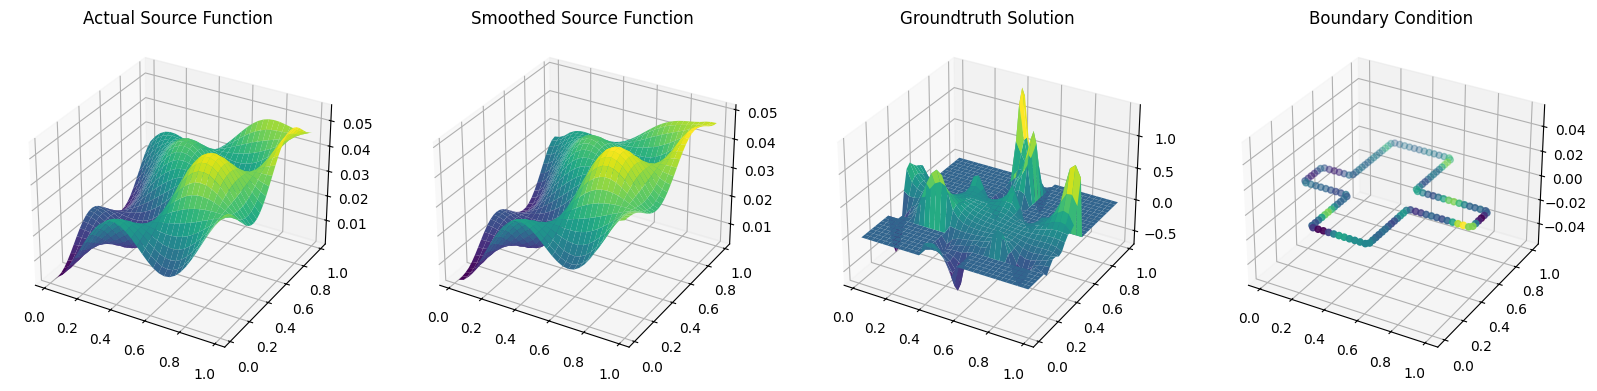

In [10]:
i = 3
x_mesh = coord_all[i,:, 0].reshape(32, 32)
y_mesh = coord_all[i,:, 1].reshape(32, 32)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, subplot_kw={"projection": "3d"}, figsize=(20, 5))

ax1.plot_surface(x_mesh, y_mesh, all_a[i,:].reshape(32, 32), cmap="viridis")
ax1.set_title("Actual Source Function")

ax2.plot_surface(x_mesh, y_mesh, all_a_reshape[i], cmap="viridis")
ax2.set_title("Smoothed Source Function")

ax3.plot_surface(x_mesh, y_mesh, all_u[i].reshape(32, 32), cmap="viridis")
ax3.set_title("Groundtruth Solution")

x_mesh_bc = bc_euco[i][:,0]
y_mesh_bc = bc_euco[i][:,1]

ax4.scatter(x_mesh_bc, y_mesh_bc, c=bc_euco[i,:,2], cmap="viridis")
ax4.set_title("Boundary Condition")
plt.show()

In [11]:
X,  Y = np.meshgrid(x_mesh_bc, y_mesh_bc)


Text(0.5, 1.0, 'Boundary Condition')

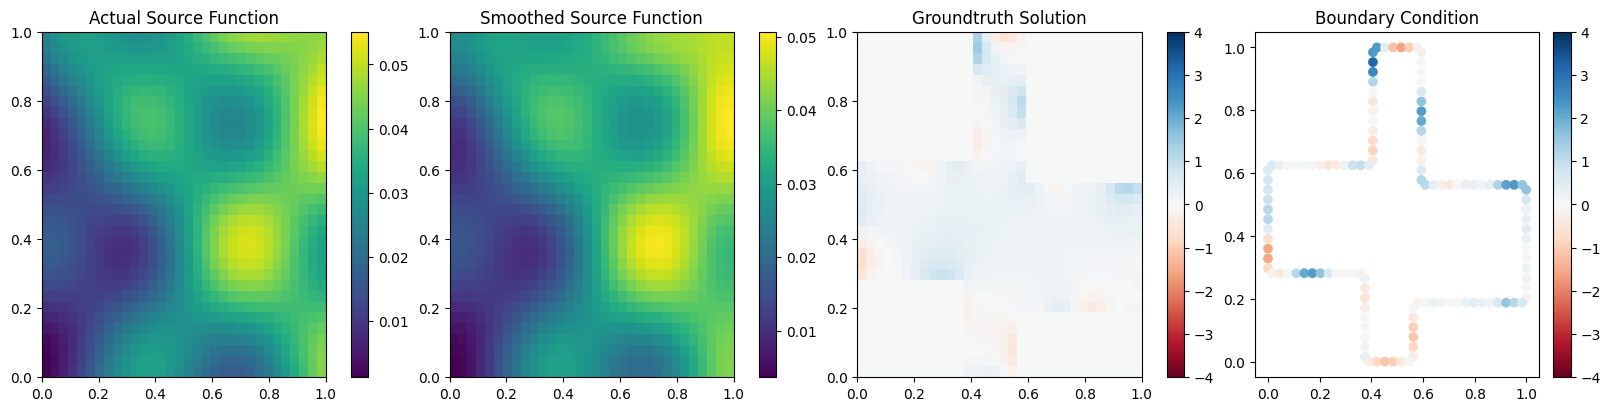

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)
from matplotlib import cm

i = 3
absmax = np.max(np.abs(all_a[i,:]))
pcm = ax1.pcolormesh(x_mesh, y_mesh, all_a[i,:].reshape(32, 32), shading='auto', cmap="viridis")
fig.colorbar(pcm, ax=ax1)
ax1.set_title("Actual Source Function")

absmax = np.max(np.abs(all_a_reshape[i]))
pcm = ax2.pcolormesh(x_mesh, y_mesh, all_a_reshape[i], shading='auto', cmap="viridis")
fig.colorbar(pcm, ax=ax2)
ax2.set_title("Smoothed Source Function")

absmax = np.max(np.abs(all_u[i]))
pcm = ax3.pcolormesh(x_mesh, y_mesh, all_u[i].reshape(32,32), shading='auto', cmap="RdBu", vmin=-4, vmax=4)
fig.colorbar(pcm, ax=ax3)
ax3.set_title("Groundtruth Solution")

absmax = np.max(np.abs(bc_euco[i,:,2]))
pcm = ax4.scatter(y_mesh_bc, x_mesh_bc, c=bc_euco[i,:,2], cmap="RdBu", vmin=-4, vmax=4)
fig.colorbar(pcm, ax=ax4)
ax4.set_title("Boundary Condition")


# 3. Normalization

In [13]:
# Process in-domain and out-of-domain data separately
indomain_a = np.array([])
indomain_u = np.array([])

for j in range(ntrain):
    outdomain_idx=np.array([],dtype=int)
    indomain_idx=np.array([],dtype=int)
    for p in range(f_all.shape[1]): 
        # If the cell is not in-domain, add it to the out-of-domain index
        if (cells_state[j][p]!=0):  
            outdomain_idx=np.append(outdomain_idx,int(p))
            
    # If the cell is in-domain, add it to the in-domain index
    indomain_idx = list(set([i for i in range(resolution*resolution)]) - set(list(outdomain_idx)))
    indomain_u = np.append(indomain_u,sol_all[j][indomain_idx])
    indomain_a = np.append(indomain_a,f_all[j][indomain_idx][:,2])

# Convert to tensors
indomain_u=torch.tensor(indomain_u)                 
indomain_a=torch.tensor(indomain_a)

# Initialize normalizers for in-domain data
a_normalizer = GaussianNormalizer(indomain_a) 
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)


# Normalize the smoothed source function
as_normalizer = GaussianNormalizer(train_a_smooth)
train_a_smooth = as_normalizer.encode(train_a_smooth)
test_a_smooth = as_normalizer.encode(test_a_smooth)

# Normalize the gradient of the source function
agx_normalizer = GaussianNormalizer(train_a_gradx)
train_a_gradx = agx_normalizer.encode(train_a_gradx)
test_a_gradx = agx_normalizer.encode(test_a_gradx)
agy_normalizer = GaussianNormalizer(train_a_grady)
train_a_grady = agy_normalizer.encode(train_a_grady)
test_a_grady = agy_normalizer.encode(test_a_grady)

# Normalize the solution function
u_normalizer = GaussianNormalizer(x=indomain_u)  
train_u = u_normalizer.encode(train_u)




## 4. Graph Construction

First construct graph data for train dataset.

In [44]:
# Initialize mesh generator
grid_input=f_all[-1,:,0:2]  # grid_inpus is of shape 1024*2 which is the coordinates of all nodes
meshgenerator = MeshGenerator([[0,1],[0,1]],[s,s], grid_input = grid_input)


# Construct graph data for training
data_train = []
for j in range(ntrain):
    mesh_idx_temp=[p for p in range(resolution**2)]
    outdomain_idx=np.array([])
    for p in range(f_all.shape[1]): 
        if (cells_state[j][p]!=0):  # = 0 means the cell is in domain
            outdomain_idx=np.append(outdomain_idx,p)
    for p in range(len(outdomain_idx)):
            mesh_idx_temp.remove(outdomain_idx[p])

    
    dist2bd_x=np.array([0,0])[np.newaxis,:]
    dist2bd_y=np.array([0,0])[np.newaxis,:]
    
    # Compute distance to boundary for each point in the mesh
    for p in range(len(mesh_idx_temp)):
        indomain_x = coord_all[j][mesh_idx_temp[p]][0] # e.g. 0.5
        indomain_y = coord_all[j][mesh_idx_temp[p]][1] # e.g. 0.3
        
        # Find boundary points that have the same x-coordinate (0.5)
        horizon_bd_y = np.where(bc_euco_train[j,:,0].round(4) == indomain_x.round(4))[0]
        
        # Calculate distances to these boundary points
        dist2bd_y_temp = np.array(
            [np.abs(bc_euco_train[j,horizon_bd_y[0],1] - indomain_y),
             np.abs(bc_euco_train[j,horizon_bd_y[1],1] - indomain_y)
            ]
        )
        dist2bd_y = np.vstack([dist2bd_y,dist2bd_y_temp[np.newaxis,:]])
        
        # Find boundary points that have the same y-coordinate (0.3)
        horizon_bd_x = np.where(bc_euco_train[j,:,1].round(4) == indomain_y.round(4))[0]
        
        # Calculate distances to these boundary points
        dist2bd_x_temp = np.array(
            [np.abs(bc_euco_train[j,horizon_bd_x[0],0] - indomain_x),
             np.abs(bc_euco_train[j,horizon_bd_x[1],0] - indomain_x)
            ]
        )
        dist2bd_x = np.vstack([dist2bd_x,dist2bd_x_temp[np.newaxis,:]])
        
        
    dist2bd_y = torch.tensor(dist2bd_y[1:]).float()
    dist2bd_x = torch.tensor(dist2bd_x[1:]).float() # [num, 2]

    
    idx = meshgenerator.sample(mesh_idx_temp)  #这一步只是将indomain的idx输入，并赋给get_grid
    grid = meshgenerator.get_grid()
    
    xx=to_np_array(grid[:,0])
    yy=to_np_array(grid[:,1])
    triang = tri.Triangulation(xx, yy)
    tri_edge = triang.edges    

    edge_index = meshgenerator.ball_connectivity(ns=10,tri_edge=tri_edge)
    edge_attr = meshgenerator.attributes(theta=train_a[j,:]) # theta is the source function, used for attributes
    train_x = torch.cat([grid, train_a[j, idx].reshape(-1, 1),
                             train_a_smooth[j, idx].reshape(-1, 1), train_a_gradx[j, idx].reshape(-1, 1),
                             train_a_grady[j, idx].reshape(-1, 1), dist2bd_x,dist2bd_y
                            ], dim=1)
    train_x_2 = torch.cat([grid, torch.zeros([grid.shape[0],4]), dist2bd_x,dist2bd_y
                            ], dim=1)
    
    bd_coord_input = torch.tensor(bc_euco_train[j])  
        
    bd_coord_input_1=bd_coord_input.clone()
    bd_coord_input_1[:,2]=0
    
    # Add edge features for boundary conditions
    bd_idx = [p for p in range(len(bd_coord_input))]
    bd_grid_input = bd_coord_input[:, 0:2]
    
    # Create a generator
    bd_meshgenerator = MeshGenerator([[0,1],[0,1]],[s,s], grid_input = bd_grid_input)
    idx = bd_meshgenerator.sample(bd_idx) 
    bd_grid = bd_meshgenerator.get_grid()
    
    # Boudnary edge features for non zero
    bd_edge_index = bd_meshgenerator.ball_connectivity(ns=3)
    bd_edge_attr = bd_meshgenerator.attributes(theta=bd_coord_input[:,2]) # theta is the source function, used for attributes

    # Boudnary edge features for non zero
    bd_edge_index_1 = bd_meshgenerator.ball_connectivity(ns=3)
    bd_edge_attr_1 = bd_meshgenerator.attributes(theta=bd_coord_input_1[:,2]) # theta is the source function, used for attributes
    
    data=HeteroData() 
    data['G1'].x=train_x #node features ▲u=f
    data['G1'].boundary=bd_coord_input_1 #boundary value=0
    data['G1'].edge_features=edge_attr
    data['G1'].sample_idx=idx
    data['G1'].edge_index=edge_index
    data['G1'].bd_edge_index=bd_edge_index
    data['G1'].bd_edge_features=bd_edge_attr
    
    data['G2'].x=train_x_2  ##node features ▲u=0
    data['G2'].boundary=bd_coord_input #boundary value=g(x)
    data['G2'].edge_features=edge_attr
    data['G2'].sample_idx=idx
    data['G2'].edge_index=edge_index
    data['G2'].bd_edge_index=bd_edge_index_1
    data['G2'].bd_edge_features=bd_edge_attr_1
            
    data['G1+2'].y=train_u[j, idx]
    
    data_train.append(data)



In [36]:
bd_grid_input = bc_euco_train[-1]
bd_grid_input.shape

(128, 3)

A visual representation of the boundary distance calculation is like this

(0.0,1.0) -------- (0.5,1.0) -------- (1.0,1.0)
    |                   |                  |
    |                   | 0.7              |
    |                   |                  |
(0.0,0.3) --- 0.5 --- P(0.5,0.3) -- 0.5 --(1.0,0.3)
    |                   |                  |
    |                   | 0.3              |
    |                   |                  |
(0.0,0.0) -------- (0.5,0.0) -------- (1.0,0.0)

   •----•----•----•
   |\   |\   |\   |
   | \  | \  | \  |
   |  \ |  \ |  \ |
   •----•----•----•
   |\   |\   |\   |
   | \  | \  | \  |
   |  \ |  \ |  \ |
   •----•----•----•

In [46]:

data_test = []
for j in range(ntest):
    mesh_idx_temp=[p for p in range(resolution**2)]
    outdomain_idx=np.array([])
    for p in range(f_all.shape[1]): 
        if (cells_state[j+ntrain][p]!=0):  
            outdomain_idx=np.append(outdomain_idx,p)
        
    for p in range(len(outdomain_idx)):
            mesh_idx_temp.remove(outdomain_idx[p])     
    
    dist2bd_x=np.array([0,0])[np.newaxis,:]
    dist2bd_y=np.array([0,0])[np.newaxis,:]
    for p in range(len(mesh_idx_temp)):
        indomain_x = coord_all[j+ntrain][mesh_idx_temp[p]][0]
        indomain_y = coord_all[j+ntrain][mesh_idx_temp[p]][1]
        
        horizon_bd_y = np.where(bc_euco_test[j,:,0].round(4) == indomain_x.round(4))[0]
        
        dist2bd_y_temp = np.array(
            [np.abs(bc_euco_test[j,horizon_bd_y[0],1] - indomain_y),
             np.abs(bc_euco_test[j,horizon_bd_y[1],1] - indomain_y)
            ]
        )
        dist2bd_y = np.vstack([dist2bd_y,dist2bd_y_temp[np.newaxis,:]])
        horizon_bd_x = np.where(bc_euco_test[j,:,1].round(4) == indomain_y.round(4))[0]
       
        dist2bd_x_temp = np.array(
            [np.abs(bc_euco_test[j,horizon_bd_x[0],0] - indomain_x),
             np.abs(bc_euco_test[j,horizon_bd_x[1],0] - indomain_x)
            ]
        )
        dist2bd_x = np.vstack([dist2bd_x,dist2bd_x_temp[np.newaxis,:]])
    dist2bd_y = torch.tensor(dist2bd_y[1:]).float()
    dist2bd_x = torch.tensor(dist2bd_x[1:]).float() # [num, 2]
   
 
    
    idx = meshgenerator.sample(mesh_idx_temp)
    grid = meshgenerator.get_grid()
    
    xx=to_np_array(grid[:,0])   
    yy=to_np_array(grid[:,1])
    triang = tri.Triangulation(xx, yy)
    tri_edge = triang.edges    

    edge_index = meshgenerator.ball_connectivity(ns=10,tri_edge=tri_edge)
    edge_attr = meshgenerator.attributes(theta=test_a[j,:])
    
    test_x = torch.cat([grid, test_a[j, idx].reshape(-1, 1),
                        test_a_smooth[j, idx].reshape(-1, 1), test_a_gradx[j, idx].reshape(-1, 1),
                        test_a_grady[j, idx].reshape(-1, 1),dist2bd_x,dist2bd_y
                       ], dim=1)
    test_x_2 = torch.cat([grid, torch.zeros([grid.shape[0],4]), dist2bd_x,dist2bd_y
                            ], dim=1)
    
    # Add edge features for boundary conditions
    bd_idx = [p for p in range(len(bd_coord_input))]
    
    bd_grid_input = bd_coord_input[:, 0:2]
    
    # Create a generator
    bd_meshgenerator = MeshGenerator([[0,1],[0,1]],[s,s], grid_input = bd_grid_input)
    idx = bd_meshgenerator.sample(bd_idx) 
    bd_grid = bd_meshgenerator.get_grid()
    
    # Boudnary edge features for non zero
    bd_edge_index = bd_meshgenerator.ball_connectivity(ns=3)
    bd_edge_attr = bd_meshgenerator.attributes(theta=bd_coord_input[:,2]) # theta is the source function, used for attributes

    # Boudnary edge features for non zero
    bd_edge_index_1 = bd_meshgenerator.ball_connectivity(ns=3)
    bd_edge_attr_1 = bd_meshgenerator.attributes(theta=bd_coord_input_1[:,2]) # theta is the source function, used for attributes
    
    data=HeteroData() 
    data['G1'].x=test_x #node features ▲u=f
    data['G1'].boundary=bd_coord_input_1 #boundary value=0
    data['G1'].edge_features=edge_attr
    data['G1'].sample_idx=idx
    data['G1'].edge_index=edge_index
    data['G1'].bd_edge_index=bd_edge_index
    data['G1'].bd_edge_features=bd_edge_attr
    
    data['G2'].x=test_x_2  ##node features ▲u=0
    data['G2'].boundary=bd_coord_input #boundary value=g(x)
    data['G2'].edge_features=edge_attr
    data['G2'].sample_idx=idx
    data['G2'].edge_index=edge_index
    data['G2'].bd_edge_index=bd_edge_index_1
    data['G2'].bd_edge_features=bd_edge_attr_1
    
    data['G1+2'].y=test_u[j, idx]
    
    data_test.append(data)

In [49]:
print(f"{len(data_train)} training data")
print(f" Training data examples: {data_train[0]}")
print(f"{len(data_test)} testing data")
print(f" Testing data examples: {data_test[0]}")

7 training data
 Training data examples: HeteroData(
  G1={
    x=[537, 10],
    boundary=[128, 3],
    edge_features=[6733, 7],
    sample_idx=[128],
    edge_index=[2, 6733],
    bd_edge_index=[2, 568],
    bd_edge_features=[568, 7],
  },
  G2={
    x=[537, 10],
    boundary=[128, 3],
    edge_features=[6733, 7],
    sample_idx=[128],
    edge_index=[2, 6733],
    bd_edge_index=[2, 568],
    bd_edge_features=[568, 7],
  },
  G1+2={ y=[128] }
)
3 testing data
 Testing data examples: HeteroData(
  G1={
    x=[544, 10],
    boundary=[128, 3],
    edge_features=[6802, 7],
    sample_idx=[128],
    edge_index=[2, 6802],
    bd_edge_index=[2, 582],
    bd_edge_features=[582, 7],
  },
  G2={
    x=[544, 10],
    boundary=[128, 3],
    edge_features=[6802, 7],
    sample_idx=[128],
    edge_index=[2, 6802],
    bd_edge_index=[2, 582],
    bd_edge_features=[582, 7],
  },
  G1+2={ y=[128] }
)


What each component represent
1. G1: the graph that solves $\Delta u = f$ with zero boundary.
    - x = [num\_nodes, num\_node\_features]: features include coordinates, a(x, y), smoothed a, gradients, distance to boundary

    - boundary = [num\_boundary\_nodes, 3] : number of nodes that are on the boundaries, 3 values are x y coordinates and boundar value which is 0 

    - edge\_features = [num\_edges, num\_edge\_features]: features are [x1,y1, x2, y2, theta1, theta2, distance]

    - sample\_indx = [num\_nodes]:  Indices of the mesh points being used
    - edge_index = [2, num\_edges]:  Connectivity matrix: 2 rows (source,target), 6733 edges
    - bd_edge_index = [2, num_edges_on_boundary]: connectivity matrix of 2 rows on the boudnary
    - bd_edge_features = [num\_edges\_on\_boundary, num\_edge\_features\_on\_ boundaries]: features are [x1,y1, x2, y2, 0, 0, distance]

2.  G2: that graph solves $\Delta u = 0$ with given boundary condition $g(x)$ 
    - x = [num\_nodes, num\_node\_features]: Same structure as G1 but different features, zero source term instead of f

    - boundary = [num\_boundary\_nodes, 3] : Boundary points with actual boundary values g(x)

    - edge\_features = [num\_edges, num\_edge\_features]: Same edge features as G1
    - sample\_indx = [num\_nodes]:  Same indices as G1
    - edge_index = [2, num\_edges]:  Same connectivity as G1

3. G1+2: Combined solution target
    - y = [num\_target\_nodes]: values of solution at the target nodes
)


# 5. Load Data and Models

In [52]:
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size2, shuffle=False)
t2 = default_timer()

logger.info('preprocessing finished, time used:{}', t2-t1)
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

if args.act == 'leakyrelu':
    activation = nn.LeakyReLU
elif args.act == 'elu':
    activation = nn.ELU
elif args.act == 'relu':
    activation = nn.ReLU
else:
    activation = nn.SiLU
    
model = HeteroGNS(nnode_in_features = node_features, nnode_out_features = 1, nedge_in_features = edge_features, nmlp_layers=args.nmlp_layers,
             activation = activation,boundary_dim = args.boundary_dim,trans_layer = trans_layer).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=16, T_mult=2)
myloss = LpLoss(size_average=False)
u_normalizer.cuda(device)
ttrain = np.zeros((epochs, ))
ttest = np.zeros((epochs,))
model.train()

data_record = {}

2025-03-31 01:11:50.725 | INFO     | __main__:<module>:5 - preprocessing finished, time used:3507.48444749997


In [53]:
model

HeteroGNS(
  (_encoder): Encoder(
    (node_fn): Sequential(
      (0): Sequential(
        (NN-0): Linear(in_features=10, out_features=128, bias=True)
        (Act-0): SiLU()
        (NN-1): Linear(in_features=128, out_features=128, bias=True)
        (Act-1): SiLU()
        (NN-2): Linear(in_features=128, out_features=128, bias=True)
        (Act-2): SiLU()
        (NN-3): Linear(in_features=128, out_features=128, bias=True)
        (Act-3): Identity()
      )
      (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (edge_fn): Sequential(
      (0): Sequential(
        (NN-0): Linear(in_features=7, out_features=128, bias=True)
        (Act-0): SiLU()
        (NN-1): Linear(in_features=128, out_features=128, bias=True)
        (Act-1): SiLU()
        (NN-2): Linear(in_features=128, out_features=128, bias=True)
        (Act-2): SiLU()
        (NN-3): Linear(in_features=128, out_features=128, bias=True)
        (Act-3): Identity()
      )
      (1): LayerNorm((128,), e

Try out the model

In [156]:
data_train[0]

HeteroData(
  G1={
    x=[537, 10],
    boundary=[128, 3],
    edge_features=[6733, 7],
    sample_idx=[537],
    edge_index=[2, 6733],
  },
  G2={
    x=[537, 10],
    boundary=[128, 3],
    edge_features=[6733, 7],
    sample_idx=[537],
    edge_index=[2, 6733],
  },
  G1+2={ y=[537] }
)

In [164]:
data = data_train[0]
x, edge_index, edge_features,boundary = data['G1'].x, data['G1'].edge_index, data['G1'].edge_features,data['G1'].boundary

x_inbd, edge_inbd_index, edge_inbd_features,boundary_inbd = data['G2'].x, data['G2'].edge_index,data['G2'].edge_features,data['G2'].boundary


In [165]:

x, edge_features,x_inbd,edge_inbd_features = model._encoder(x, edge_features,x_inbd,edge_inbd_features)
print(x.shape, edge_features.shape,x_inbd.shape,edge_inbd_features.shape)

torch.Size([537, 128]) torch.Size([6733, 128]) torch.Size([537, 128]) torch.Size([6733, 128])


In [ ]:

x, edge_features, x_inbd, edge_inbd_features = model._processor(x, edge_index, edge_features, boundary,x_inbd,edge_inbd_index, edge_inbd_features,boundary_inbd)
print(x.shape, edge_features.shape, x_inbd.shape, edge_inbd_features.shape)

torch.Size([537, 128]) torch.Size([6733, 128]) torch.Size([537, 128]) torch.Size([6733, 128])


In [168]:

u = model._decoder(x,x_inbd)
u.shape

torch.Size([537, 1])

In [169]:

out = model(data)
out.shape

torch.Size([537, 1])

### Check the transformer architecture for boundary encoding.

In [174]:
boundary.shape

torch.Size([128, 3])

In [54]:
transformer = model._processor.gnn_stacks[0].boundary_fn
transformer

Transformer(
  (enc_embedding): DataEmbedding_wo_temp(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(3, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 128)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 128)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 128)
      )
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 128)
      )
    )
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0, inplace=False)
          )
          (query_projection): Linear(in_features=128, out_features=128, bias=True)
          (key_

The transformer performs input embedding and passes the embedding into the encoder.

The procedure of embedding is as below

In [186]:
enc_out = transformer.enc_embedding(x=boundary.unsqueeze(0).float(),x_mark=None)
enc_out.shape


torch.Size([1, 128, 128])

And this embedding as passed on to the encoder

In [ ]:
out, attns = transformer.encoder(enc_out, attn_mask=None)
out.shape


torch.Size([1, 128, 128])

In [55]:
transformer.encoder

Encoder(
  (attn_layers): ModuleList(
    (0-2): 3 x EncoderLayer(
      (attention): AttentionLayer(
        (inner_attention): FullAttention(
          (dropout): Dropout(p=0, inplace=False)
        )
        (query_projection): Linear(in_features=128, out_features=128, bias=True)
        (key_projection): Linear(in_features=128, out_features=128, bias=True)
        (value_projection): Linear(in_features=128, out_features=128, bias=True)
        (out_projection): Linear(in_features=128, out_features=128, bias=True)
      )
      (conv1): Conv1d(128, 16, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(16, 128, kernel_size=(1,), stride=(1,))
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)

In [195]:
encoder = transformer.encoder
encoder_layers = encoder.attn_layers
encoder_layer_example = encoder.attn_layers[0]
attn_example = encoder_layer_example.attention
conv1_example = encoder_layer_example.conv1
conv2_example = encoder_layer_example.conv2




One encoder layer, containing attention layer, normalization and convolution layer

In [ ]:
x = encoder_layer_example(enc_out, attn_mask=None)

new_x, attn = attn_example(enc_out, enc_out, enc_out, attn_mask=None)

x = enc_out + encoder_layer_example.dropout(new_x)
y = conv1_example(new_x.transpose(-1,1))
y = conv2_example(y).transpose(-1,1)


specifically look at attention

In [ ]:
attention = attn_example.inner_attention
query_projection = attn_example.query_projection
key_projection = attn_example.key_projection
value_projection = attn_example.value_projection    
out_projection = attn_example.out_projection


In [233]:
query_projection

Linear(in_features=128, out_features=128, bias=True)

In [226]:
B, L, D = enc_out.shape
H = 2
S = L

In [228]:
queries = query_projection(enc_out).view(B, L,H, -1)
keys = key_projection(enc_out).view(B, S, H, -1)
values = value_projection(enc_out).view(B, S, H, -1)

out, attn = attention(
    queries,
    keys,
    values,
    None
)




In [231]:
print(queries.shape, keys.shape, values.shape)
print(out.shape, attn)

torch.Size([1, 128, 2, 64]) torch.Size([1, 128, 2, 64]) torch.Size([1, 128, 2, 64])
torch.Size([1, 128, 2, 64]) None


In [232]:
out = out.view(B, L, -1)
out.shape

torch.Size([1, 128, 128])

Conduct max pooling on the last dimension

In [194]:
out = transformer.GMP(out.permute(0,2,1)).squeeze(-1)
out.shape


torch.Size([1, 128])

In [179]:
boundary_embdding = transformer(boundary.unsqueeze(0).float())
boundary_embdding.shape


torch.Size([1, 128])

Model predicts the solution on the indomain nodes.

In [155]:
a = torch.rand(3, 2)
a.repeat(2, 1)

tensor([[0.9034, 0.0070],
        [0.5492, 0.5291],
        [0.7225, 0.7464],
        [0.9034, 0.0070],
        [0.5492, 0.5291],
        [0.7225, 0.7464]])

### Try GPS


In [62]:
from transformer import *
import torch
from torch.nn import (
    BatchNorm1d,
    Embedding,
    Linear,
    ModuleList,
    ReLU,
    Sequential,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch_geometric.transforms as T
from torch_geometric.nn import GINEConv, GPSConv, global_add_pool
from torch_geometric.nn.attention import PerformerAttention
from torch_geometric.utils import to_networkx

from typing import Dict, Any, Optional
from BE_MPNN import *

In [ ]:

class GPS(torch.nn.Module):
    def __init__(self, enc_in, d_model: int, GPSConv_layers: int,
                 attn_type= "multihead", attn_kwargs={"dropout": 0, "bias": False,"batch_first": False}, 
                 n_heads = 4, d_ff = 16, activation = 'gelu'):
        
        super().__init__()

        channels = d_model
        self.node_emb = DataEmbedding_wo_temp(enc_in,d_model)


        self.convs = ModuleList()
        for _ in range(GPSConv_layers):
            nn = Sequential(
                Linear(d_model, d_model),
                activation,
                Linear(d_model, d_model),
            )
            conv = GPSConv(d_model, GINEConv(nn), heads=n_heads,
                           attn_type=attn_type, attn_kwargs=attn_kwargs)
            self.convs.append(conv)

        self.mlp = Sequential(
            Linear(channels, channels // 2),
            ReLU(),
            Linear(channels // 2, channels // 4),
            ReLU(),
            Linear(channels // 4, 1),
        )
        self.GMP = torch.nn.AdaptiveMaxPool1d(1, return_indices=False)
        self.redraw_projection = RedrawProjection(
            self.convs,
            redraw_interval=1000 if attn_type == 'performer' else None)

    def forward(self, x, edge_index, edge_attr,batch=None):
        x = self.node_emb(x)
        
        edge_attr = self.edge_emb(edge_attr)

        for conv in self.convs:
            x = conv(x, edge_index, batch, edge_attr=edge_attr)
        out = self.GMP(out.permute(0,2,1)).squeeze(-1)
        return out


SyntaxError: unterminated string literal (detected at line 4) (3138569666.py, line 4)

In [67]:
max_pool = torch.nn.AdaptiveMaxPool1d
max_pool

torch.nn.modules.pooling.AdaptiveMaxPool1d

In [63]:
class RedrawProjection:
    def __init__(self, model: torch.nn.Module,
                 redraw_interval: Optional[int] = None):
        self.model = model
        self.redraw_interval = redraw_interval
        self.num_last_redraw = 0

    def redraw_projections(self):
        if not self.model.training or self.redraw_interval is None:
            return
        if self.num_last_redraw >= self.redraw_interval:
            fast_attentions = [
                module for module in self.model.modules()
                if isinstance(module, PerformerAttention)
            ]
            for fast_attention in fast_attentions:
                fast_attention.redraw_projection_matrix()
            self.num_last_redraw = 0
            return
        self.num_last_redraw += 1

# 6. Train!

In [13]:
for ep in range(epochs):
    model.train() #改的
    t1 = default_timer()
    train_mse = 0.0
    train_l2 = 0.0
    for batch in train_loader:

        # n = np.random.randint(2)
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.mse_loss(out.view(-1, 1), batch['G1+2'].y.view(-1,1))

        loss.backward()
        l2 = myloss(
            u_normalizer.decode(out.view(batch_size, -1), sample_idx=batch['G1'].sample_idx.view(batch_size, -1)),
            u_normalizer.decode(batch['G1+2'].y.view(batch_size, -1), sample_idx=batch['G1'].sample_idx.view(batch_size, -1))) #G1和G2的sanmple_idx是一样的
        
        # pdb.set_trace()
        optimizer.step()
        train_mse += loss.item()
        train_l2 += l2.item()

    scheduler.step()
    t2 = default_timer()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            out = u_normalizer.decode(out.view(batch_size2,-1), sample_idx=batch['G1'].sample_idx.view(batch_size2,-1))
            test_l2 += myloss(out, batch['G1+2'].y.view(batch_size2, -1)).item()

    t3 = default_timer()
    ttrain[ep] = train_l2/(ntrain)
    ttest[ep] = test_l2/ntest
    logger.info(f"Epoch {ep:03d}     train_Loss: {train_mse/len(train_loader):.6f}  \t train_L2: {train_l2/(ntrain):.6f}\t test_L2: {test_l2/ntest:.6f}")
    record_data(data_record, [ep, train_mse/len(train_loader), train_l2/(ntrain), test_l2/ntest], ["epoch", "train_MSE", "train_L2", "test_L2"])
    if ep % inspect_interval == 0 or ep == epochs - 1:
        record_data(data_record, [ep, to_cpu(model.state_dict())], ["save_epoch", "state_dict"])
        pickle.dump(data_record, open(path_model, "wb"))

2025-03-28 16:27:47.995 | INFO     | __main__:<module>:39 - Epoch 000     train_Loss: 1.105272  	 train_L2: 1.046779	 test_L2: 1.003433


KeyboardInterrupt: 